# 作业2 用神经网络实现与非门

X=1 Y=0

X=0 Y=1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path
from matplotlib.colors import LogNorm

In [2]:
class NeuralNet(object):
    def __init__(self, params):
        self.params = params
        self.W = np.zeros((self.params.input_size, self.params.output_size))
        self.B = np.zeros((1, self.params.output_size))

    def forward(self, batch_x):
        Z = np.dot(batch_x, self.W) + self.B
        return Z

    def backward(self, batch_x, batch_y, batch_z):
        m = batch_x.shape[0]
        dZ = batch_z - batch_y
        dB = dZ.sum(axis=0, keepdims=True)/m
        dW = np.dot(batch_x.T, dZ)/m
        return dW, dB

    def update(self, dW, dB):
        self.W = self.W - self.params.eta * dW
        self.B = self.B - self.params.eta * dB

    def checkLoss(self, dataReader):
        X,Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        Z = self.forward(X)
        LOSS = (Z - Y)**2
        loss = LOSS.sum()/m/2
        return loss
    
    def inference(self, x):
        return self.forward(x)
#end class NeuralNet

In [3]:
class SimpleDataReader(object):
    def __init__(self):
        self.train_file_name = "data/ch05.npz"
        self.num_train = 0
        self.XTrain = None
        self.YTrain = None
        self.XRaw = None
        self.YRaw = None

    # read data from file
    def ReadData(self):
        train_file = Path(self.train_file_name)
        if train_file.exists():
            data = np.load(self.train_file_name)
            self.XRaw = data["data"]
            self.YRaw = data["label"]
            self.num_train = self.XRaw.shape[0]
            self.XTrain = self.XRaw
            self.YTrain = self.YRaw
        else:
            raise Exception("Cannot find train file!!!")
        #end if

    def NormalizeX(self):
        X_new = np.zeros(self.XRaw.shape)
        num_feature = self.XRaw.shape[1]
        self.X_norm = np.zeros((num_feature,2))
        for i in range(num_feature):            
            col_i = self.XRaw[:,i]
            max_value = np.max(col_i)
            min_value = np.min(col_i)            
            self.X_norm[i,0] = min_value             
            self.X_norm[i,1] = max_value - min_value 
            new_col = (col_i - self.X_norm[i,0])/(self.X_norm[i,1])
            X_new[:,i] = new_col
        #end for
        self.XTrain = X_new

    def NormalizePredicateData(self, X_raw):
        X_new = np.zeros(X_raw.shape)
        n = X_raw.shape[1]
        for i in range(n):
            col_i = X_raw[:,i]
            X_new[:,i] = (col_i - self.X_norm[i,0]) / self.X_norm[i,1]
        return X_new

    def NormalizeY(self):
        self.Y_norm = np.zeros((1,2))
        max_value = np.max(self.YRaw)
        min_value = np.min(self.YRaw)
        self.Y_norm[0, 0] = min_value 
        self.Y_norm[0, 1] = max_value - min_value 
        y_new = (self.YRaw - min_value) / self.Y_norm[0, 1]
        self.YTrain = y_new

    # get batch training data
    def GetSingleTrainSample(self, iteration):
        x = self.XTrain[iteration]
        y = self.YTrain[iteration]
        return x, y

    # get batch training data
    def GetBatchTrainSamples(self, batch_size, iteration):
        start = iteration * batch_size
        end = start + batch_size
        batch_X = self.XTrain[start:end,:]
        batch_Y = self.YTrain[start:end,:]
        return batch_X, batch_Y

    def GetWholeTrainSamples(self):
        return self.XTrain, self.YTrain

    def Shuffle(self):
        seed = np.random.randint(0,100)
        np.random.seed(seed)
        XP = np.random.permutation(self.XTrain)
        np.random.seed(seed)
        YP = np.random.permutation(self.YTrain)
        self.XTrain = XP
        self.YTrain = YP
#end class SimpleDataReader

In [6]:
class HyperParameters(object):
    def __init__(self, input_size, output_size, eta=0.1, max_epoch=1000, batch_size=5, eps=0.1):
        self.input_size = input_size
        self.output_size = output_size
        self.eta = eta
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.eps = eps

    def toString(self):
        title = str.format("bz:{0},eta:{1}", self.batch_size, self.eta)
        return title
#end class HyperParameters 

In [7]:
class TrainingHistory(object):
    def __init__(self):
        self.iteration = []
        self.loss_history = []
        self.w_history = []
        self.b_history = []

    def AddLossHistory(self, iteration, loss, w, b):
        self.iteration.append(iteration)
        self.loss_history.append(loss)
        self.w_history.append(w)
        self.b_history.append(b)

    def ShowLossHistory(self, params, xmin=None, xmax=None, ymin=None, ymax=None):
        plt.plot(self.iteration, self.loss_history)
        title = params.toString()
        plt.title(title)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        if xmin != None and ymin != None:
            plt.axis([xmin, xmax, ymin, ymax])
        plt.show()
        return title

    def GetLast(self):
        count = len(self.loss_history)
        return self.loss_history[count-1], self.w_history[count-1], self.b_history[count-1]
# end class

In [8]:
class LogicNotGateDataReader(SimpleDataReader):
    # x=0,y=1; x=1,y=0
    def ReadData(self):
        X = np.array([1,0]).reshape(2,1)
        Y = np.array([0,1]).reshape(2,1)
        self.XTrain = X
        self.YTrain = Y
        self.num_train = 2
#end LogicNotGateDataReader

In [9]:
def train02(net, dataReader):
    loss_history = TrainingHistory()

    if net.params.batch_size == -1:
        net.params.batch_size = dataReader.num_train
    max_iteration = (int)(dataReader.num_train / net.params.batch_size)
    for epoch in range(net.params.max_epoch):
        print("epoch=%d" %epoch)
        dataReader.Shuffle()
        for iteration in range(max_iteration):
            # get x and y value for one sample
            batch_x, batch_y = dataReader.GetBatchTrainSamples(net.params.batch_size, iteration)
            # get z from x,y
            batch_z = net.forward(batch_x)
            # calculate gradient of w and b
            dW, dB = net.backward(batch_x, batch_y, batch_z)
            # update w,b
            net.update(dW, dB)
            if iteration % 2 == 0:
                loss = net.checkLoss(dataReader)
                print(epoch, iteration, loss)
                loss_history.AddLossHistory(epoch*max_iteration+iteration, loss, net.W[0,0], net.B[0,0])
                if loss < net.params.eps:
                    break
                #end if
            #end if
        # end for
        if loss < net.params.eps:
            break
    # end for
    loss_history.ShowLossHistory(net.params)
    print(net.W, net.B)

In [10]:
def Test(net):
    z1 = net.inference(0)
    z2 = net.inference(1)
    print (z1,z2)
    if np.abs(z1-1) < 0.001 and np.abs(z2-0)<0.001:
        return True
    return False

In [11]:
def ShowResult(net):
    x = np.array([-0.5,0,1,1.5]).reshape(4,1)
    y = net.inference(x)
    plt.plot(x,y)
    plt.scatter(0,1,marker='^')
    plt.scatter(1,0,marker='o')
    plt.show()

epoch=0
0 0 0.25
epoch=1
1 0 0.208625
epoch=2
2 0 0.151818705
epoch=3
3 0 0.15967363990499997
epoch=4
4 0 0.1418563842007545
epoch=5
5 0 0.11432451022308268
epoch=6
6 0 0.1052853398850128
epoch=7
7 0 0.10688350784552908
epoch=8
8 0 0.08965429565171984
epoch=9
9 0 0.08951578736067747
epoch=10
10 0 0.08177071842635737
epoch=11
11 0 0.07077056895121925
epoch=12
12 0 0.06921855220412337
epoch=13
13 0 0.06346645175276242
epoch=14
14 0 0.058277427533125446
epoch=15
15 0 0.053566751656896575
epoch=16
16 0 0.04762291421904977
epoch=17
17 0 0.04368492465691225
epoch=18
18 0 0.04223089771616247
epoch=19
19 0 0.03712109234366781
epoch=20
20 0 0.034103562869812115
epoch=21
21 0 0.033192061199804626
epoch=22
22 0 0.030455255686633115
epoch=23
23 0 0.0268351924259643
epoch=24
24 0 0.025897445302609283
epoch=25
25 0 0.022794712116006536
epoch=26
26 0 0.020938267791515718
epoch=27
27 0 0.020362601498573513
epoch=28
28 0 0.017812995688599793
epoch=29
29 0 0.016374162114462
epoch=30
30 0 0.0150634786898

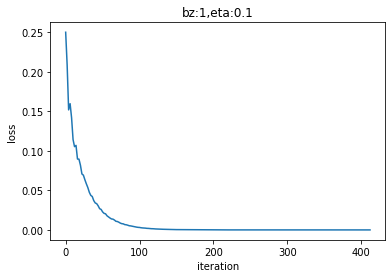

[[-0.99974129]] [[0.99982304]]
w=-0.999741,b=0.999823
[[0.99982304]] [[8.17535204e-05]]
True


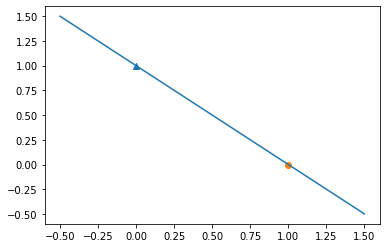

In [12]:
logicNotGateDataReader = LogicNotGateDataReader()
logicNotGateDataReader.ReadData()

params = HyperParameters(1, 1, eta=0.1, max_epoch=1000, batch_size=1, eps = 1e-8)
net = NeuralNet(params)
train02(net,logicNotGateDataReader)

print("w=%f,b=%f" %(net.W, net.B))
print(Test(net))
ShowResult(net)